In [2]:
!python -V


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


Python 3.7.12


In [3]:
import pandas as pd

In [4]:
import pickle

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [25]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment1")


2022/05/29 12:29:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2022/05/29 12:29:23 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='my-experiment1', tags={}>

In [26]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [27]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464354743487

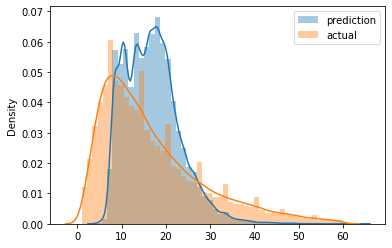

In [28]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [30]:
len(df_train), len(df_val)

(73908, 61921)

In [31]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [32]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [37]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Cristian")
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "green_tripdata_2021-02.parquet")

    alpha=0.1

    mlflow.log_param("alpha", alpha)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle/")  #saves model as file

In [34]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [48]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

In [50]:
import xgboost as xgb
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [55]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=10,  #1000
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse=mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)


        with open("models/preprocesor.b", "wb") as f_out:
            pickle.dump(dv, f_out)

        mlflow.log_artifact("models/preprocesor.b", artifact_path="preprocesor") #log model as artifact

        mlflow.xgboost.log_model(booster, artifact_path="models_mlflow") #saves model, different way

    return {'loss':rmse, 'status':STATUS_OK}

In [56]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    "min_child_weight":  hp.loguniform('min_child_weight', -1, 3),
    "objective": "reg:linear",
    "seed":42
}

mlflow.xgboost.autolog()

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[13:33:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.12958                          
[1]	validation-rmse:12.69519                          
[2]	validation-rmse:10.42166                          
[3]	validation-rmse:8.96260                           
[4]	validation-rmse:8.04661                           
[5]	validation-rmse:7.48213                           
[6]	validation-rmse:7.13799                           
[7]	validation-rmse:6.92240                           
[8]	validation-rmse:6.78627                           
[9]	validation-rmse:6.69736                           
  0%|          | 0/50 [00:56<?, ?trial/s, best loss=?]

2022/05/29 13:34:35 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:34:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 4ab71a8bac8941acab1400c76238d75e. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:34:43] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.19800                                                     
[1]	validation-rmse:17.44961                                                     
[2]	validation-rmse:15.92064                                                     
[3]	validation-rmse:14.58914                                                     
[4]	validation-rmse:13.43207                                                     
[5]	validation-rmse:12.43053                                                     
[6]	validation-rmse:11.56694                                                     
[7]	validation-rmse:10.82542                                                     
[8]	validation-rmse:10.19069                                                     
[9]	validation-rmse:9.64969                                                      
  2%|▏         | 1/50 [02:03<1:17:01, 94.32s/trial, best loss

2022/05/29 13:35:17 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:35:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 7cbd7ae63ef44bf2a7e4ba14781c8951. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:35:25] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:6.90342                                                    
[1]	validation-rmse:6.74402                                                    
[2]	validation-rmse:6.72506                                                    
[3]	validation-rmse:6.71554                                                    
[4]	validation-rmse:6.71013                                                    
[5]	validation-rmse:6.70731                                                    
[6]	validation-rmse:6.70793                                                    
[7]	validation-rmse:6.70917                                                    
[8]	validation-rmse:6.71004                                                    
[9]	validation-rmse:6.70909                                                    
  4%|▍         | 2/50 [02:43<50:27, 63.07s/trial, best loss: 6.697355464025523]

2022/05/29 13:35:57 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:36:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID fe84750fb53f4b83bd4b246fc71a4d38. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:36:05] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.79992                                                   
[1]	validation-rmse:9.09810                                                    
[2]	validation-rmse:7.62409                                                    
[3]	validation-rmse:7.05963                                                    
[4]	validation-rmse:6.84047                                                    
[5]	validation-rmse:6.73794                                                    
[6]	validation-rmse:6.68963                                                    
[7]	validation-rmse:6.66126                                                    
[8]	validation-rmse:6.64970                                                    
[9]	validation-rmse:6.63909                                                    
  6%|▌         | 3/50 [03:31<41:11, 52.58s/trial, best loss: 6.697355464025523]

2022/05/29 13:36:48 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:36:50 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8ae2a7523a4b418dac9c00f269c359c6. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:36:53] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.32489                                                   
[1]	validation-rmse:14.39220                                                   
[2]	validation-rmse:12.20278                                                   
[3]	validation-rmse:10.58861                                                   
[4]	validation-rmse:9.42026                                                    
[5]	validation-rmse:8.58984                                                    
[6]	validation-rmse:8.00121                                                    
[7]	validation-rmse:7.59103                                                    
[8]	validation-rmse:7.30739                                                    
[9]	validation-rmse:7.10551                                                    
  8%|▊         | 4/50 [04:04<38:55, 50.78s/trial, best loss: 6.639091407167929]

2022/05/29 13:37:22 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:37:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 654afd8fccdd436283abb94097e71628. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:37:31] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.18087                                                   
[1]	validation-rmse:17.42035                                                   
[2]	validation-rmse:15.88415                                                   
[3]	validation-rmse:14.54769                                                   
[4]	validation-rmse:13.38968                                                   
[5]	validation-rmse:12.38959                                                   
[6]	validation-rmse:11.52953                                                   
[7]	validation-rmse:10.79197                                                   
[8]	validation-rmse:10.16179                                                   
[9]	validation-rmse:9.62588                                                    
 10%|█         | 5/50 [04:52<34:40, 46.23s/trial, best loss: 6.639091407167929]

2022/05/29 13:38:04 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:38:07 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 6649a6f2391948f4b9d3ae8a6747872a. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:38:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.63315                                                   
[1]	validation-rmse:18.22352                                                   
[2]	validation-rmse:16.95588                                                   
[3]	validation-rmse:15.80724                                                   
[4]	validation-rmse:14.77962                                                   
[5]	validation-rmse:13.85279                                                   
[6]	validation-rmse:13.02481                                                   
[7]	validation-rmse:12.28138                                                   
[8]	validation-rmse:11.62143                                                   
[9]	validation-rmse:11.02678                                                   
 12%|█▏        | 6/50 [05:45<32:22, 44.15s/trial, best loss: 6.639091407167929]

2022/05/29 13:39:25 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:39:27 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID d0f20fb6522249d2850380dc99f69dc7. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:39:30] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:17.78617                                                   
[1]	validation-rmse:15.10797                                                   
[2]	validation-rmse:13.02559                                                   
[3]	validation-rmse:11.42066                                                   
[4]	validation-rmse:10.20281                                                   
[5]	validation-rmse:9.28444                                                    
[6]	validation-rmse:8.60295                                                    
[7]	validation-rmse:8.10571                                                    
[8]	validation-rmse:7.73607                                                    
[9]	validation-rmse:7.46971                                                    
 14%|█▍        | 7/50 [06:31<39:51, 55.62s/trial, best loss: 6.639091407167929]

2022/05/29 13:39:43 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:39:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2cf04d5244cb4eadadb849f24f05025a. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:39:48] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.98804                                                   
[1]	validation-rmse:12.52502                                                   
[2]	validation-rmse:10.28193                                                   
[3]	validation-rmse:8.88255                                                    
[4]	validation-rmse:8.02845                                                    
[5]	validation-rmse:7.51503                                                    
[6]	validation-rmse:7.20481                                                    
[7]	validation-rmse:7.02075                                                    
[8]	validation-rmse:6.90106                                                    
[9]	validation-rmse:6.82608                                                    
 16%|█▌        | 8/50 [06:42<30:31, 43.62s/trial, best loss: 6.639091407167929]

2022/05/29 13:39:54 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.

2022/05/29 13:39:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID bbecf1a7b4bc45c79a0b0b0586261af0. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'num_boost_round\', \'old_value\': None, \'new_value\': \'10\'}, {\'key\': \'early_stopping_rounds\', \'old_value\': None, \'new_value\': \'50\'}, {\'key\': \'maximize\', \'old_value\': None, \'new_value\': \'None\'}, {\'key\': \'verbose_eval\', \'old_value\': None, \'new_value\': \'True\'}, {\'key\': \'custom_metric\', \'old_value\': None, \'new_value\': \'None\'}]\' fo

[13:39:59] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
 18%|█▊        | 9/50 [07:01<31:58, 46.78s/trial, best loss: 6.639091407167929]


KeyboardInterrupt: 

In [59]:
#load model using mlflow and Pandas df

import mlflow
logged_model = 'runs:/8ae2a7523a4b418dac9c00f269c359c6/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model
# # Predict on a Pandas DataFrame.
# import pandas as pd
# loaded_model.predict(pd.DataFrame(data))

[13:42:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 8ae2a7523a4b418dac9c00f269c359c6

In [60]:
#load model using xgboost

xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[13:42:50] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [62]:
#predict
y_pred = xgboost_model.predict(valid)
y_pred[:10]


array([15.105437 ,  7.1527705, 21.169924 , 26.080473 ,  9.350628 ,
       17.028702 , 12.609461 ,  9.100959 ,  9.262997 , 19.783064 ],
      dtype=float32)

In [65]:
#mlflow client

from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='my-experiment1', tags={}>]

In [98]:
# client.create_experiment(name="my-experiment2")

from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids="1",
    filter_string="metrics.rmse < 10",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    # order_by="metrics.rmse ASC"
)

for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics.get('rmse')}")

run id: bbecf1a7b4bc45c79a0b0b0586261af0, rmse: 6.826080363148807
run id: 2cf04d5244cb4eadadb849f24f05025a, rmse: 7.4697065781696015
run id: 6649a6f2391948f4b9d3ae8a6747872a, rmse: 9.625880502971388
run id: 654afd8fccdd436283abb94097e71628, rmse: 7.105505210627173
run id: 8ae2a7523a4b418dac9c00f269c359c6, rmse: 6.639091407167929


In [109]:
run_id = "654afd8fccdd436283abb94097e71628"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name = "green2")
client.list_registered_models()

Registered model 'green2' already exists. Creating a new version of this model...
2022/05/29 14:26:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: green2, version 3
Created version '3' of model 'green2'.


[<RegisteredModel: creation_timestamp=1653825644001, description='', last_updated_timestamp=1653825748057, latest_versions=[<ModelVersion: creation_timestamp=1653825660574, current_stage='Staging', description='', last_updated_timestamp=1653825748057, name='green1', run_id='bbecf1a7b4bc45c79a0b0b0586261af0', run_link='', source='./mlruns/1/bbecf1a7b4bc45c79a0b0b0586261af0/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=2>], name='green1', tags={}>,
 <RegisteredModel: creation_timestamp=1653826880012, description=None, last_updated_timestamp=1653827205670, latest_versions=[<ModelVersion: creation_timestamp=1653827205670, current_stage='None', description=None, last_updated_timestamp=1653827205670, name='green2', run_id='654afd8fccdd436283abb94097e71628', run_link=None, source='./mlruns/1/654afd8fccdd436283abb94097e71628/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>], name='green2', tags={}>]

In [112]:
model_name = "green1"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 2, stage: Staging
version: 3, stage: None


In [113]:
# transition model

client.transition_model_version_stage(
    name=model_name,
    version=3,
    stage="Staging",
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1653827292756, current_stage='Staging', description='', last_updated_timestamp=1653827404112, name='green1', run_id='654afd8fccdd436283abb94097e71628', run_link='', source='./mlruns/1/654afd8fccdd436283abb94097e71628/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [114]:
# update a model

client.update_model_version(
    name=model_name,
    version=3,
    description=f"version: 3, stage: Staging"

)

<ModelVersion: creation_timestamp=1653827292756, current_stage='Staging', description='version: 3, stage: Staging', last_updated_timestamp=1653827543544, name='green1', run_id='654afd8fccdd436283abb94097e71628', run_link='', source='./mlruns/1/654afd8fccdd436283abb94097e71628/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=3>